##### STAGE 06 - MODEL TRAINING PIPELINE WITHOUT SCALING NUMERICAL FEATURES ONLY FOR TREE-BASED ALGORITHMS

`Justifications for not scaling numerical features - essential ingredients for real-life project`

##### A tree-based models usually do not need their numerical features `scaled` because trees determines splits based on `feature ordering` but not `feature magnitude (distance)` and ignore reduntant features automatically.

##### However, numerical features scaling maybe necessary if and only if:
1. Combining tree-based models with linear booster (booster="gblinear") -->> This behaves like linear models + SGD and scaling improves convergence and stability.

2. Features differ by many orders of magnitude (distance) -->> Extremely large values can affect how split gain is calculated and occasionally causing instability. Also, scaling may improve training speed in this case.

3. Combining tree-based models with distance-based models in pipeline -->> If you ensemble tree-based with distance-based models (KNN, SVM, NN), scaling are needed for the distance-based models so pipelines scales everything uniformly.

`Industry-based approach: if scaling is cheap and fits the industry pipeline, including it is harmless and may improve numeric stability.`

##### If you are using tree-based models for your training removing multicollinearity features are not required and this is because tree-based models select the best split among correlated features, uses regularization (L1/L2) to penalize unnecessary splits and uses column subsampling (colsample_bytree, colsample_bylevel) to reduce overfitting caused by correlated variables. Also, tree-based models do not compute coefficient estimates i.e. no inflated variance issues, thier performance rarely decreases due to correlation.

##### It is worth to note that, Feature importance interpretation is the only area where multicollinearity causes confusion which means that if your focus is on interpretability or extremely high-dimensional data, then you can consider removing multicollinear features. Only remove correlated features if:

1. You want simpler / interpretable models -->> features with 0.99 correlation confuse importance metrics like gain or SHAP similarity.

2. You have extremely high-dimensional data --> if there are thousands of nearly identical features, removing redundancy reduces: Memory usage, Training time and Noise.

3. You observed that correlated features causes data leakage -->> the target leakage via feature engineering especially the ones that mirror the target.

##### Instead of removing multicollinear features you can focus more on:

1. Perform good feature engineering.

2. Avoid data leakage.

3. Perform proper model tuning.

4. Perform robust validation.


##### SAMPLES OF TREE-BASED MODELS THAT DOES NOT NEED NUMERICAL FEATURE SCALING OR REMOVING MULTICOLLINEARITY

`Random Forest`

1. Tree-based model → uses splits, not distances.

2. Robust to correlated features; picks whichever split yields highest gain.

3. No scaling needed.

`Gradient Boosting`

1. Similar to XGBoost but built into scikit-learn.

3. Tree-based, unaffected by scales or correlations.

`LightGBM`

1. Tree boosting model from Microsoft.

2. Histogram-based splitting, scale-invariant.

3. Handles multicollinearity well due to leaf-wise growing.

`CatBoost`

1. Also tree-based, with categorical encoding support.

2. Works fine with unscaled, correlated features.

3. Built-in L2 regularization reduces effect of redundancy.

`Extra Trees (Extremely Randomized Trees)`

1. Tree ensemble like Random Forest but more randomness.

2. Completely scale-invariant.

3. Naturally deals with correlated/duplicate features by random selection.

`Decision Tree`

Basis for all tree ensembles.

1. Purely splitting-based and ignores magnitudes.

2. Multicollinearity does not hurt model quality.

`Histogram-Based Gradient Boosting (sklearn’s HGB)`

1. Variant of gradient boosting that discretizes features into bins.

2. Insensitive to scaling.

3. Correlated features only add redundant splits, not instability.


`TRAINING FIVE (5) TREE-BASED MODELS ON THE DATASETS`

In [4]:
# ===========================================================
# IMPORT REQUIRED LIBRARIES
# ===========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [5]:
# =============================================================
# LOAD PROCESSED DATA
# =============================================================
train_data = pd.read_csv("../data/processed_data/engineered_train_df_without_multicoll.csv")
eval_data = pd.read_csv("../data/processed_data/engineered_eval_df_without_multicoll.csv")

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576815 entries, 0 to 576814
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   month                         576815 non-null  int64  
 1   quarter                       576815 non-null  int64  
 2   year                          576815 non-null  int64  
 3   median_ppsf                   576815 non-null  float64
 4   homes_sold                    576815 non-null  float64
 5   pending_sales                 576815 non-null  float64
 6   new_listings                  576815 non-null  float64
 7   inventory                     576815 non-null  float64
 8   median_dom                    576815 non-null  float64
 9   avg_sale_to_list              576815 non-null  float64
 10  sold_above_list               576815 non-null  float64
 11  off_market_in_two_weeks       576815 non-null  float64
 12  zipcode                       576815 non-nul

In [9]:
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

Numerical columns: ['month', 'quarter', 'year', 'median_ppsf', 'homes_sold', 'pending_sales', 'new_listings', 'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list', 'off_market_in_two_weeks', 'zipcode', 'bus', 'hospital', 'mall', 'park', 'restaurant', 'school', 'station', 'Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty', 'Total Housing Units', 'Median Rent', 'Total Labor Force', 'Unemployed Population', 'Total School Age Population', 'Total School Enrollment', 'Median Commute Time', 'price', 'lat', 'lng', 'zipcode_freq', 'city_full_encoded']
Categorical columns: []


`Since there are no categorical features in the datasets, then we are not going scale the numerical features because we would be using the tree-based models to train the datasets.`

`X_train, y_train, X_eval, y_eval`

In [12]:
target_col = "price"
feature_cols = [col for col in train_data.columns if col != target_col]
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_eval = eval_data[feature_cols]
y_eval = eval_data[target_col]

`Baseline Model for tree-based algorithms for the features unscaled`

In [11]:
baseline = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
    )
baseline

,n_estimators,500
,criterion,'squared_error'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# =============================================================
# MODEL TRAINING
# =============================================================

baseline.fit(X_train, y_train)
y_pred_baseline = baseline.predict(X_eval)

In [14]:
def metric_evaluation(y_pred, y_eval):
    mse = mean_squared_error(y_pred, y_eval)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_pred, y_eval)
    r2 = r2_score(y_pred, y_eval)

    print("The baseline model metrics are: ")
    print(f"ROOT_MEAN_SQUARED_ERROR:  {rmse:,.2f}")
    print(f"MEAN_ABSOLUTE_ERROR:  {mae:,.2f}")
    print(f"COEFFICIENT_OF_DETERMINATION: {r2*100:,.2f}%")

metric_evaluation(y_pred_baseline, y_eval)

The baseline model metrics are: 
ROOT_MEAN_SQUARED_ERROR:  201,409.90
MEAN_ABSOLUTE_ERROR:  118,075.83
COEFFICIENT_OF_DETERMINATION: 71.43%


##### `DEVELOP AN ENSEMBLE TREE-BASED MODELS (4 TREE-BASED ENSEMBLE)`

###### `INSTANTIATE 4 TREE-BASED MODELS DICTIONARY`

In [15]:
MODELS = {
    "XGBRegressor": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "GRADIENTBOOSTINGREGRESSOR": GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        random_state=42
    ),
    "HISTGRADIENTBOOSTINGREGRESSOR": HistGradientBoostingRegressor(
        max_iter=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ),
    "EXTRATREESREGRESSOR": ExtraTreesRegressor(
        n_estimators=500,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
}

In [16]:
# =============================================================
# MODEL TRAINING AND EVALUATION
# =============================================================

RESULTS = {}
for model_name, model in MODELS.items():
    print(f"Training {model_name}...")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_eval)

    print(f"Evaluation metrics for {model_name}:")
    metric_evaluation(y_pred, y_eval)
    print("+" * 50)

    RESULTS[model_name] = {
        "MSE": mean_squared_error(y_eval, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_eval, y_pred)),
        "MAE": mean_absolute_error(y_eval, y_pred),
        "R2": r2_score(y_eval, y_pred)
    }

Training XGBRegressor...
Evaluation metrics for XGBRegressor:
The baseline model metrics are: 
ROOT_MEAN_SQUARED_ERROR:  237,181.74
MEAN_ABSOLUTE_ERROR:  188,302.10
COEFFICIENT_OF_DETERMINATION: 66.82%
++++++++++++++++++++++++++++++++++++++++++++++++++
Training GRADIENTBOOSTINGREGRESSOR...
Evaluation metrics for GRADIENTBOOSTINGREGRESSOR:
The baseline model metrics are: 
ROOT_MEAN_SQUARED_ERROR:  232,288.08
MEAN_ABSOLUTE_ERROR:  179,583.18
COEFFICIENT_OF_DETERMINATION: 68.78%
++++++++++++++++++++++++++++++++++++++++++++++++++
Training HISTGRADIENTBOOSTINGREGRESSOR...
Evaluation metrics for HISTGRADIENTBOOSTINGREGRESSOR:
The baseline model metrics are: 
ROOT_MEAN_SQUARED_ERROR:  284,572.20
MEAN_ABSOLUTE_ERROR:  225,267.30
COEFFICIENT_OF_DETERMINATION: 54.55%
++++++++++++++++++++++++++++++++++++++++++++++++++
Training EXTRATREESREGRESSOR...
Evaluation metrics for EXTRATREESREGRESSOR:
The baseline model metrics are: 
ROOT_MEAN_SQUARED_ERROR:  141,713.13
MEAN_ABSOLUTE_ERROR:  85,675.87
COE

###### `DATAFRAME FOR METRICS FOR THE TREE-BASED ALGORITHMS`

In [17]:
RESULTS_df = pd.DataFrame(RESULTS).T
RESULTS_df = RESULTS_df.sort_values(by="RMSE")
RESULTS_df

,MSE,RMSE,MAE,R2
EXTRATREESREGRESSOR,2.008261e+10,141713.134340,85675.866515,0.844804
GRADIENTBOOSTINGREGRESSOR,5.395775e+10,232288.077691,179583.180699,0.583021
XGBRegressor,5.625518e+10,237181.741061,188302.101764,0.565267
HISTGRADIENTBOOSTINGREGRESSOR,8.098134e+10,284572.203329,225267.297415,0.374186


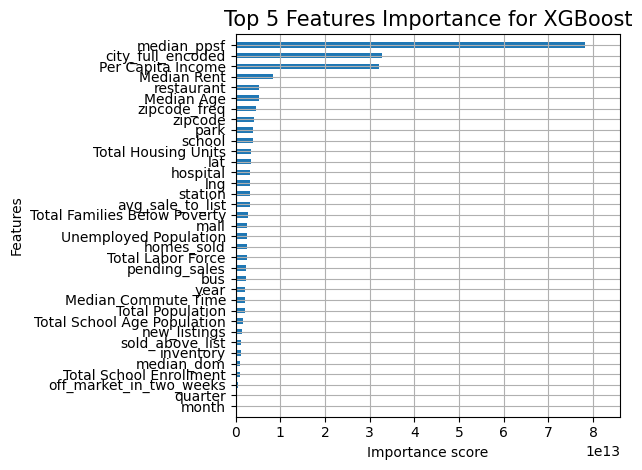

In [47]:
# PLOTTING THE FEATURES IMPORTANCE USING THE XGBREGRESSOR MODEL
for model_name, model in MODELS.items():
    if model_name == "XGBRegressor":
        plot_importance(
            model,
            importance_type="gain",
            max_num_features=len(X_train.columns),
            height=0.5,
            show_values=False
        )
        plt.title("Top 5 Features Importance for XGBoost", fontsize=15)
        plt.tight_layout()
        plt.show()

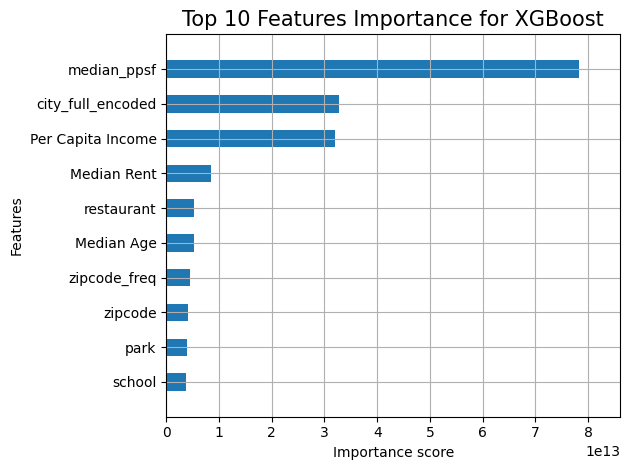

In [42]:
# PLOTTING THE TOP 10 FEATURES IMPORTANCE USING THE XGBREGRESSOR MODEL

for model_name, model in MODELS.items():
    if model_name == "XGBRegressor":

        booster = model.get_booster()
        booster.feature_names = feature_cols

        plot_importance(
            booster,
            importance_type="gain",
            max_num_features=10,
            height=0.5,
            show_values=False
        )
        plt.title("Top 10 Features Importance for XGBoost", fontsize=15)
        plt.tight_layout()
        plt.show()

##### `PLOTTING THE TOP 10 FEATURES IMPORTANCE FOR ALL THE MODELS`

In [ ]:
def plot_feature_importance(model, model_name, feature_names, top_n=10):

    # FOR XGBOOST MODELS
    if hasattr(model, "get_booster"):
        importance = model.get_booster().get_score(importance_type="gain")
        importance = pd.Series(importance)

    # FOR SKLEARN AND TREE-BASED MODELS
    elif hasattr(model, "feature_importances_"):
        importance = pd.Series(
            model.feature_importances_,
            index=feature_names
        )

    else:
        print(f"{model_name} does not support feature importance.")
        return

    importance = importance.sort_values(ascending=False).head(top_n)

    importance.plot(kind="barh")
    plt.title(f"Top {top_n} Feature Importances ({model_name})")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


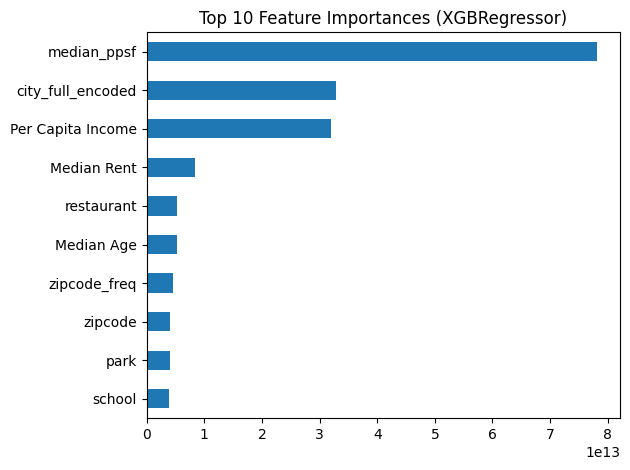

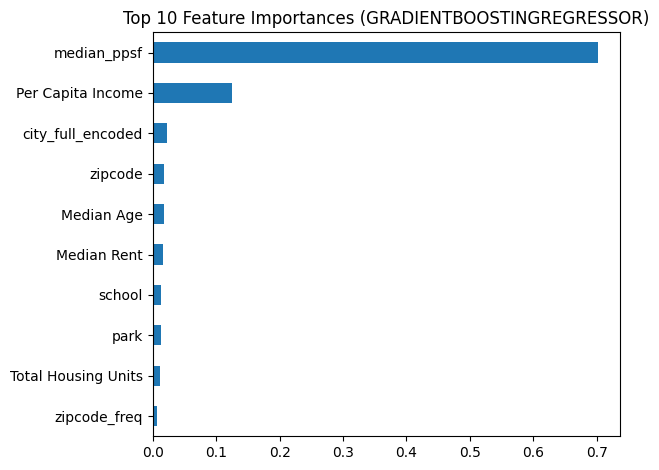

HISTGRADIENTBOOSTINGREGRESSOR does not support feature importance.


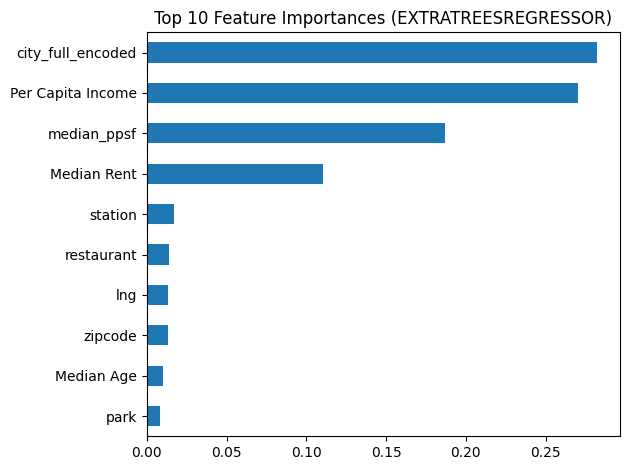

In [46]:
for model_name, model in MODELS.items():
    plot_feature_importance(
        model=model,
        model_name=model_name,
        feature_names=X_train.columns
    )


###### `SAVING THE CHOICE BEST MODEL`

In [53]:
for model_name, model in MODELS.items():
    if model_name == "EXTRATREESREGRESSOR":
        with open(f"../model/trained_{model_name}_model_without_scaling.pkl", "wb") as file:
            pickle.dump(model, file)
            print(f"✅ {model_name} as best model is saved successfully.")

✅ EXTRATREESREGRESSOR as best model is saved successfully.
